In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import libraries
from pandas import read_csv
from matplotlib import pyplot
from numpy import sqrt
import warnings
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [3]:
series = read_csv('https://raw.githubusercontent.com/mchandak/DS_Repo10/main/Data/water.csv', header=0, index_col=0, parse_dates=True)

In [26]:
series

,Water
Year,
1885-01-01,356
1886-01-01,386
1887-01-01,397
1888-01-01,397
1889-01-01,413
...,...
1959-01-01,594
1960-01-01,587
1961-01-01,587


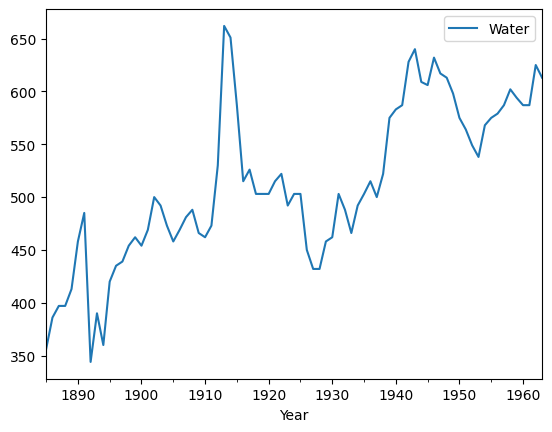

In [5]:
# line plot of time series
from pandas import read_csv
from matplotlib import pyplot
series.plot()
pyplot.show()

array([[<AxesSubplot: title={'center': 'Water'}>]], dtype=object)

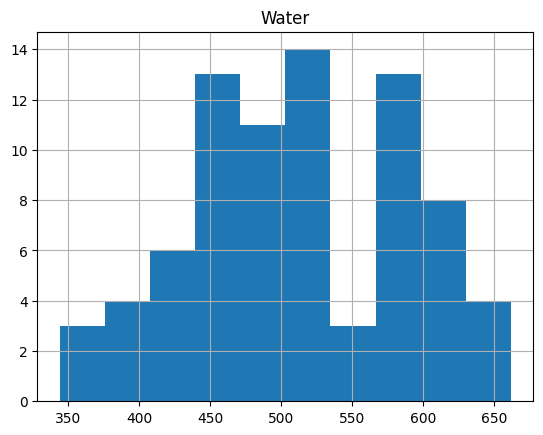

In [6]:
series.hist()

<AxesSubplot: ylabel='Density'>

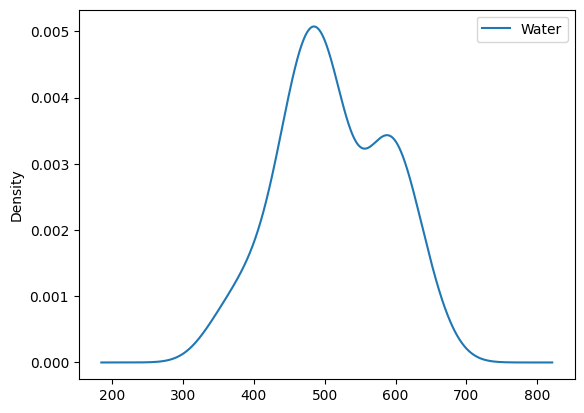

In [7]:
series.plot(kind='kde')

In [8]:
# separate out a validation dataset
split_point = len(series) - 10
dataset, validation = series[0:split_point], series[split_point:]
print('Dataset %d, Validation %d' % (len(dataset), len(validation)))
dataset.to_csv('dataset.csv', header=True)
validation.to_csv('validation.csv', header=True)

Dataset 69, Validation 10


#### Persistence/ Base model

In [9]:
# evaluate a persistence model
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from math import sqrt
# load data
train = read_csv('dataset.csv', index_col=0, parse_dates=True, squeeze=True)
# prepare data
X = train.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]


In [10]:
# walk-forward validation
history = [x for x in train]
predictions = []
for i in range(len(test)):
    yhat = history[-1]
    predictions.append(yhat)
# observation
    obs = test[i]
    history.append(obs)
    print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))
# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)

>Predicted=503.000, Expected=503.000
>Predicted=503.000, Expected=503.000
>Predicted=503.000, Expected=515.000
>Predicted=515.000, Expected=522.000
>Predicted=522.000, Expected=492.000
>Predicted=492.000, Expected=503.000
>Predicted=503.000, Expected=503.000
>Predicted=503.000, Expected=450.000
>Predicted=450.000, Expected=432.000
>Predicted=432.000, Expected=432.000
>Predicted=432.000, Expected=458.000
>Predicted=458.000, Expected=462.000
>Predicted=462.000, Expected=503.000
>Predicted=503.000, Expected=488.000
>Predicted=488.000, Expected=466.000
>Predicted=466.000, Expected=492.000
>Predicted=492.000, Expected=503.000
>Predicted=503.000, Expected=515.000
>Predicted=515.000, Expected=500.000
>Predicted=500.000, Expected=522.000
>Predicted=522.000, Expected=575.000
>Predicted=575.000, Expected=583.000
>Predicted=583.000, Expected=587.000
>Predicted=587.000, Expected=628.000
>Predicted=628.000, Expected=640.000
>Predicted=640.000, Expected=609.000
>Predicted=609.000, Expected=606.000
>

#### ARIMA Hyperparameters

In [11]:
# grid search ARIMA parameters for a time series

import warnings
from pandas import read_csv
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt


# evaluate an ARIMA model for a given order (p,d,q) and return RMSE
def evaluate_arima_model(X, arima_order):
# prepare training dataset
    X = X.astype('float32')
    train_size = int(len(X) * 0.50)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
# make predictions
    predictions = []
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
# model_fit = model.fit(disp=0)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
# calculate out of sample error
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse

#### Grid search for p,d,q values

In [12]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float('inf'), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                  rmse = evaluate_arima_model(train, order)
                  if rmse < best_score:
                      best_score, best_cfg = rmse, order
                      print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

In [13]:
train

array([356., 386., 397., 397., 413., 458., 485., 344., 390., 360., 420.,
       435., 439., 454., 462., 454., 469., 500., 492., 473., 458., 469.,
       481., 488., 466., 462., 473., 530., 662., 651., 587., 515., 526.,
       503.], dtype=float32)

In [14]:
# load dataset
train = read_csv('https://raw.githubusercontent.com/mchandak/DS_Repo10/main/Data/water.csv', index_col=0, parse_dates=True, squeeze=True)
# evaluate parameters
p_values = range(1, 5)
d_values = range(1, 5)
q_values = range(1, 5)
warnings.filterwarnings("ignore")
evaluate_models(train, p_values, d_values, q_values)

Best ARIMANone RMSE=inf


#### Build Model based on the optimized values

In [15]:
# save finalized model to file
from pandas import read_csv
from statsmodels.tsa.arima.model import ARIMA
import numpy

In [24]:
# load data
train = read_csv('dataset.csv', header=0, index_col=0, parse_dates=True)
# prepare data
X = train.values
X = X.astype('float32')

In [34]:
train

Index(['Water'], dtype='object')

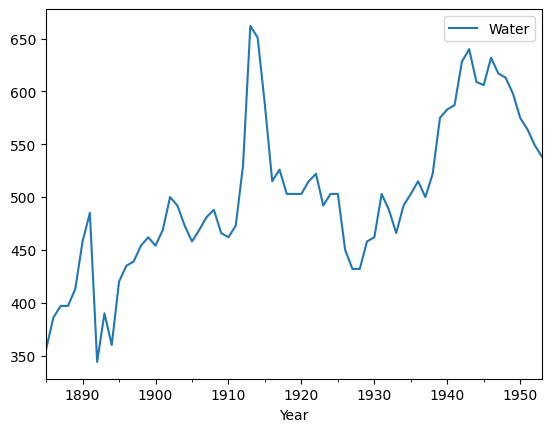

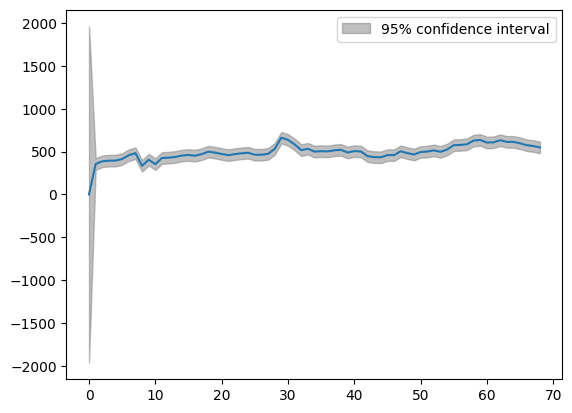

In [42]:
# fit model
from statsmodels.graphics.tsaplots import plot_predict
model = ARIMA(X, order=(2,1,0))
model_fit = model.fit()
forecast=model_fit.forecast(steps=10)[0]
fig, ax = plt.subplots()
ax = train.plot(ax=ax)
plot_predict(model_fit)
plt.show()

In [ ]:
#Error on the test data
val=pd.read_csv('validation.csv')
rmse = sqrt(mean_squared_error(val.Water, forecast))
rmse

#### Combine train and test data and build final model

In [ ]:
# fit model
data = read_csv('https://raw.githubusercontent.com/mchandak/DS_Repo10/main/Data/water.csv', header=0, index_col=0, parse_dates=True)
# prepare data
X = train.values
X = X.astype('float32')

In [ ]:
model = ARIMA(X, order=(4,1,0))
model_fit = model.fit()

In [ ]:
forecast=model_fit.forecast(steps=10)[0]
model_fit.plot_predict(1,90)